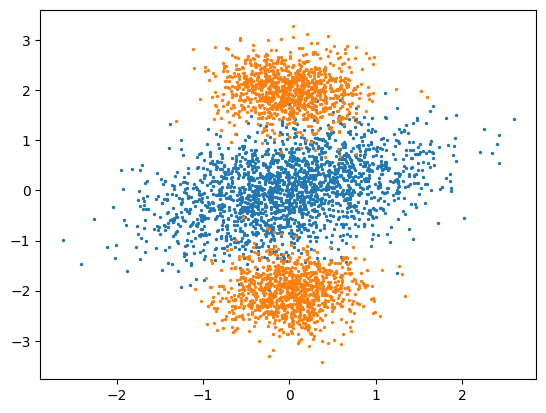

i: 0, loss: 1.2820954567391982
i: 1, loss: 0.7448536792312789
i: 2, loss: 0.31002579530199675
i: 3, loss: 0.2020614673705685
i: 4, loss: 0.06568177175705606
i: 5, loss: 0.13490807144379857
i: 6, loss: 0.08503559032989289
i: 7, loss: 0.10016831944931914
i: 8, loss: 0.07575975356701312
i: 9, loss: 0.05488679215692368
i: 10, loss: 0.07237103425887083
i: 11, loss: 0.06042444530857763
i: 12, loss: 0.046885225511252834
i: 13, loss: 0.052619018722602835
i: 14, loss: 0.045644625082116384
i: 15, loss: 0.033955473791824016
i: 16, loss: 0.04266938832798182
i: 17, loss: 0.044873299687103324
i: 18, loss: 0.03767830233800029
i: 19, loss: 0.03831368744355671
i: 20, loss: 0.03826247880560816
i: 21, loss: 0.03148914878284387
i: 22, loss: 0.026811391639311972
i: 23, loss: 0.03016455292734635
i: 24, loss: 0.028076939825227142
i: 25, loss: 0.026123436303516993
i: 26, loss: 0.02742021430811272
i: 27, loss: 0.027961944850044752
i: 28, loss: 0.025775782636370134
i: 29, loss: 0.025537447522022323
i: 30, loss:

In [11]:
import math
import jax
import jax.numpy as jnp
import numpy as np
import optax
import matplotlib.pyplot as plt
from flax import linen as nn
from fbs.nn.utils import make_nn_with_time
from fbs.dsb import ipf_loss, simulate_discrete_time

jax.config.update("jax_enable_x64", True)

# Config
nsamples = 2000
niters = 500
key = jax.random.PRNGKey(666)
nn_float = jnp.float64
nn_param_init = nn.initializers.xavier_normal()

dt = 0.01
nsteps = 100
T = nsteps * dt
ts = jnp.linspace(0, T, nsteps + 1)


# Toy data
def sample_x0s(_key):
    _, _subkey = jax.random.split(_key)
    ss = jax.random.normal(_subkey, (nsamples, 2)) @ jnp.linalg.cholesky(jnp.array([[0.5, 0.2],
                                                                                    [0.2, 0.5]]))
    return jnp.array([0., 0.]) + ss


def sample_xTs(_key):
    _key, _subkey = jax.random.split(_key)
    _c1 = jnp.array([0., 2.]) + 0.4 * jax.random.normal(_subkey, (int(nsamples / 2), 2))
    _key, _subkey = jax.random.split(_key)
    _c2 = jnp.array([0., -2.]) + 0.4 * jax.random.normal(_subkey, (int(nsamples / 2), 2))
    return jnp.concatenate([_c1, _c2], axis=0)


key, subkey = jax.random.split(key)
x0s = sample_x0s(subkey)
key, subkey = jax.random.split(key)
xTs = sample_xTs(subkey)
plt.scatter(x0s[:, 0], x0s[:, 1], s=2)
plt.scatter(xTs[:, 0], xTs[:, 1], s=2)
plt.show()


# Reference measure Brownian motion
sigma = 1.


# Neural network construction
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=128, param_dtype=nn_float, kernel_init=nn_param_init)(x)
        x = nn.relu(x)
        x = nn.Dense(features=64, param_dtype=nn_float, kernel_init=nn_param_init)(x)
        x = nn.relu(x)
        x = nn.Dense(features=2, param_dtype=nn_float, kernel_init=nn_param_init)(x)
        return jnp.squeeze(x)


mlp = MLP()
key, subkey = jax.random.split(key)
init_param_fwd, _, nn_fwd = make_nn_with_time(mlp, dim_in=2, batch_size=10, time_scale=5, key=subkey)
key, subkey = jax.random.split(key)
init_param_bwd, _, nn_bwd = make_nn_with_time(mlp, dim_in=2, batch_size=10, time_scale=5, key=subkey)

schedule = optax.exponential_decay(1e-2, niters, 0.9)
optimiser = optax.adam(learning_rate=schedule)
f_param = init_param_fwd
b_param = init_param_bwd


# The first IPF iteration
def init_f(x, t, _): return x


@jax.jit
def optax_kernel_init(_b_param, _opt_state, _key):
    _key, _subkey = jax.random.split(_key)
    _x0s = sample_x0s(_subkey)
    _, _subkey = jax.random.split(_key)
    _loss, grad = jax.value_and_grad(ipf_loss)(_b_param, nn_bwd, init_f, _, _x0s, ts, sigma, _subkey)
    updates, _opt_state = optimiser.update(grad, _opt_state, _b_param)
    _b_param = optax.apply_updates(_b_param, updates)
    return _b_param, _opt_state, _loss


@jax.jit
def optax_kernel_fwd(_b_param, _opt_state, _f_param, _key):
    _key, _subkey = jax.random.split(_key)
    _x0s = sample_x0s(_subkey)
    _, _subkey = jax.random.split(_key)
    _loss, grad = jax.value_and_grad(ipf_loss)(_b_param, nn_bwd, nn_fwd, _f_param, _x0s, ts, sigma, _subkey)
    updates, _opt_state = optimiser.update(grad, _opt_state, _b_param)
    _b_param = optax.apply_updates(_b_param, updates)
    return _b_param, _opt_state, _loss


@jax.jit
def optax_kernel_bwd(_f_param, _opt_state, _b_param, _key):
    _key, _subkey = jax.random.split(_key)
    _xTs = sample_xTs(_subkey)
    _, _subkey = jax.random.split(_key)
    _loss, grad = jax.value_and_grad(ipf_loss)(_f_param, nn_fwd, nn_bwd, _b_param, _xTs, ts, sigma, _subkey)
    updates, _opt_state = optimiser.update(grad, _opt_state, _f_param)
    _f_param = optax.apply_updates(_f_param, updates)
    return _f_param, _opt_state, _loss

opt_state = optimiser.init(b_param)

for i in range(niters):
    key, subkey = jax.random.split(key)
    b_param, opt_state, loss = optax_kernel_init(b_param, opt_state, subkey)
    print(f'i: {i}, loss: {loss}')

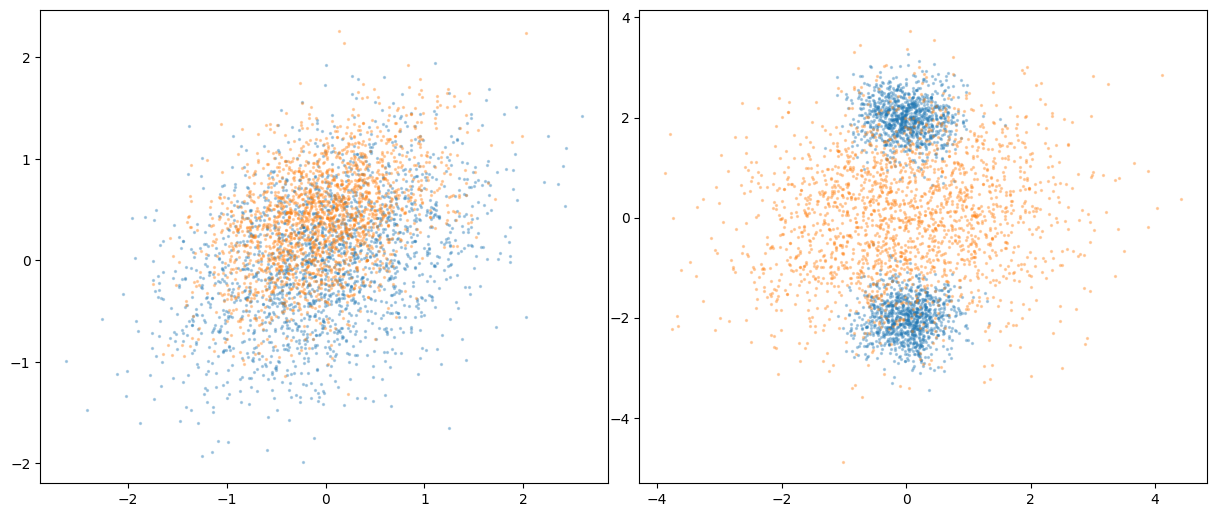

In [12]:
# Test if the reverse is learnt correctly
key, subkey = jax.random.split(key)
approx_xTs = simulate_discrete_time(init_f, x0s, ts, sigma, subkey, f_param)[:, -1, :]

key, subkey = jax.random.split(key)
approx_x0s = simulate_discrete_time(nn_bwd, xTs, ts, sigma, subkey, b_param)[:, -1, :]

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(x0s[:, 0], x0s[:, 1], s=2, alpha=0.3)
axes[0].scatter(approx_x0s[:, 0], approx_x0s[:, 1], s=2, alpha=0.3)

axes[1].scatter(xTs[:, 0], xTs[:, 1], s=2, alpha=0.3)
axes[1].scatter(approx_xTs[:, 0], approx_xTs[:, 1], s=2, alpha=0.3)

plt.tight_layout(pad=0.1)
plt.show()

In [ ]:
opt_state = optimiser.init(f_param)

for i in range(niters):
    key, subkey = jax.random.split(key)
    f_param, opt_state, loss = optax_kernel_bwd(f_param, opt_state, b_param, subkey)
    print(f'i: {i}, loss: {loss}')

i: 0, loss: 4.646685858633737
i: 1, loss: 1.9269894100444453
i: 2, loss: 0.7083400498346346
i: 3, loss: 0.4264872408194633
i: 4, loss: 0.6231251216102243
i: 5, loss: 0.6119620366478099
i: 6, loss: 0.33529594688701003
i: 7, loss: 0.16420437031449772
i: 8, loss: 0.20273701169778824
i: 9, loss: 0.2612272804229647
i: 10, loss: 0.2638944752637968
i: 11, loss: 0.21398941459630907
i: 12, loss: 0.15364954840246564
i: 13, loss: 0.11061309533477034
i: 14, loss: 0.10316215877068118
i: 15, loss: 0.10095252884203794
i: 16, loss: 0.08178629044652248
i: 17, loss: 0.07388066640228289
i: 18, loss: 0.08498636165713089
i: 19, loss: 0.08580841632762852
i: 20, loss: 0.07125607740501207
i: 21, loss: 0.054511960397062915
i: 22, loss: 0.04867886726814328
i: 23, loss: 0.047877164093288134
i: 24, loss: 0.05047239118585944
i: 25, loss: 0.05573797635887263
i: 26, loss: 0.053801930955435444
i: 27, loss: 0.04188135243739422
i: 28, loss: 0.030888397757340792
i: 29, loss: 0.026838139646967126
i: 30, loss: 0.029528723

In [ ]:
# Take a look
key, subkey = jax.random.split(key)
approx_xTs = simulate_discrete_time(nn_fwd, x0s, ts, sigma, subkey, f_param)[:, -1, :]

key, subkey = jax.random.split(key)
approx_x0s = simulate_discrete_time(nn_bwd, xTs, ts, sigma, subkey, b_param)[:, -1, :]

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(x0s[:, 0], x0s[:, 1], s=2, alpha=0.3)
axes[0].scatter(approx_x0s[:, 0], approx_x0s[:, 1], s=2, alpha=0.3)

axes[1].scatter(xTs[:, 0], xTs[:, 1], s=2, alpha=0.3)
axes[1].scatter(approx_xTs[:, 0], approx_xTs[:, 1], s=2, alpha=0.3)

plt.tight_layout(pad=0.1)
plt.show()

In [ ]:
opt_state = optimiser.init(b_param)

for i in range(niters):
    key, subkey = jax.random.split(key)
    b_param, opt_state, loss = optax_kernel_fwd(b_param, opt_state, f_param, subkey)
    print(f'i: {i}, loss: {loss}')

In [ ]:
# Take a look
key, subkey = jax.random.split(key)
approx_xTs = simulate_discrete_time(nn_fwd, x0s, ts, sigma, subkey, f_param)[:, -1, :]

key, subkey = jax.random.split(key)
approx_x0s = simulate_discrete_time(nn_bwd, xTs, ts, sigma, subkey, b_param)[:, -1, :]

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(x0s[:, 0], x0s[:, 1], s=2, alpha=0.3)
axes[0].scatter(approx_x0s[:, 0], approx_x0s[:, 1], s=2, alpha=0.3)

axes[1].scatter(xTs[:, 0], xTs[:, 1], s=2, alpha=0.3)
axes[1].scatter(approx_xTs[:, 0], approx_xTs[:, 1], s=2, alpha=0.3)

plt.tight_layout(pad=0.1)
plt.show()

In [ ]:
opt_state = optimiser.init(f_param)

for i in range(niters):
    key, subkey = jax.random.split(key)
    f_param, opt_state, loss = optax_kernel_bwd(f_param, opt_state, b_param, subkey)
    print(f'i: {i}, loss: {loss}')

In [ ]:
# Take a look
key, subkey = jax.random.split(key)
approx_xTs = simulate_discrete_time(nn_fwd, x0s, ts, sigma, subkey, f_param)[:, -1, :]

key, subkey = jax.random.split(key)
approx_x0s = simulate_discrete_time(nn_bwd, xTs, ts, sigma, subkey, b_param)[:, -1, :]

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(x0s[:, 0], x0s[:, 1], s=2, alpha=0.3)
axes[0].scatter(approx_x0s[:, 0], approx_x0s[:, 1], s=2, alpha=0.3)

axes[1].scatter(xTs[:, 0], xTs[:, 1], s=2, alpha=0.3)
axes[1].scatter(approx_xTs[:, 0], approx_xTs[:, 1], s=2, alpha=0.3)

plt.tight_layout(pad=0.1)
plt.show()

In [ ]:
opt_state = optimiser.init(b_param)

for i in range(niters):
    key, subkey = jax.random.split(key)
    b_param, opt_state, loss = optax_kernel_fwd(b_param, opt_state, f_param, subkey)
    print(f'i: {i}, loss: {loss}')

In [ ]:
# Take a look
key, subkey = jax.random.split(key)
approx_xTs = simulate_discrete_time(nn_fwd, x0s, ts, sigma, subkey, f_param)[:, -1, :]

key, subkey = jax.random.split(key)
approx_x0s = simulate_discrete_time(nn_bwd, xTs, ts, sigma, subkey, b_param)[:, -1, :]

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(x0s[:, 0], x0s[:, 1], s=2, alpha=0.3)
axes[0].scatter(approx_x0s[:, 0], approx_x0s[:, 1], s=2, alpha=0.3)

axes[1].scatter(xTs[:, 0], xTs[:, 1], s=2, alpha=0.3)
axes[1].scatter(approx_xTs[:, 0], approx_xTs[:, 1], s=2, alpha=0.3)

plt.tight_layout(pad=0.1)
plt.show()